In [68]:
import numpy as np
import matplotlib.pyplot as plt
import time
import pandas as pd

### The Layer Class

In [69]:
# defining of the Layer class.
class Layer:
    # constructor method of the class, executed when a new instance of Layer is created.
    def __init__(self):
        self.input = None
        self.output = None
    # This method is intended to be overridden by subclasses.
    # It takes an input parameter and performs the forward pass of the layer.
    def forward(self, input):
        # This line raises a NotImplementedError if the method is called directly from the base class Layer. 
        # Subclasses must implement their own forward method.
        raise NotImplementedError
    # This method is intended to be overridden by subclasses. 
    # It takes an output_grad parameter, which represents the gradient of the loss with respect to the output of the layer.
    def backward(self, output_grad):
        # This line raises a NotImplementedError if the method is called directly from the base class Layer. 
        # Subclasses must implement their own backward method.
        raise NotImplementedError

### Linear Layer

In [70]:
# It defines the LinearLayer class, which inherits from the Layer class.
class LinearLayer(Layer):
    def __init__(self, input_size, output_size):
        # the constructor of the base class Layer to initialize its attributes.
        super().__init__()
        self.input_size = input_size
        self.output_size = output_size
        # the weights of the layer with random values drawn from a normal distribution.
        self.weights = np.random.randn(input_size, output_size)
        # It initializes the bias of the layer with zeros.
        self.bias = np.zeros((1, output_size))

    def forward(self, input):
        self.input = input
        # output of the layer by multiplying the input by the weights and adding the bias.
        self.output = np.dot(input, self.weights) + self.bias
        return self.output

    def backward(self, output_grad):
        # gradient of the loss with respect to the input.
        input_grad = np.dot(output_grad, self.weights.T)
        # The gradient of the loss with respect to the weights.
        weights_grad = np.dot(self.input.T, output_grad)
        bias_grad = np.sum(output_grad, axis=0, keepdims=True)
        self.weights -= learning_rate * weights_grad
        self.bias -= learning_rate * bias_grad
        return input_grad

### Sigmoid Function

In [71]:
# sigmoid activation function.
# SigmoidLayer class encapsulates the functionality of a layer with the sigmoid activation function, including forward and backward passes
class SigmoidLayer(Layer):
    def __init__(self):
        super().__init__()

    def sigmoid(self, x):
        # the sigmoid function for an input x.
        return 1 / (1 + np.exp(-x))

    def forward(self, input):
        self.input = input
        #  the output of the layer by applying the sigmoid function to the input.
        self.output = self.sigmoid(input)
        return self.output

    # backward pass of the layer.
    def backward(self, output_grad):
        # gradient of the sigmoid function.
        sigmoid_grad = self.output * (1 - self.output)
        # gradient of the loss wrt the input using the chain rule.
        input_grad = sigmoid_grad * output_grad
        return input_grad

### Rectified Linear Unit (ReLU)

In [72]:
# ReLULayer class encapsulates the functionality of a layer with the ReLU activation function, including forward and backward passes.
class ReLULayer(Layer):
    def __init__(self):
        super().__init__()
        self.input_mask = None
    
    def forward(self, input_data):
        # creates a binary mask where True corresponds to positive values in the input and False corresponds to non-positive values.
        self.input_mask = (input_data > 0)
        return input_data * self.input_mask
    
    def backward(self, output_grad):
        return output_grad * self.input_mask

### Binary Cross-Entropy Loss

In [73]:
# BinaryCrossEntropyLoss class encapsulates the functionality of the binary cross-entropy loss function, including forward and backward passes.
# It computes the loss during the forward pass and its gradient during the backward pass.
class BinaryCrossEntropyLoss(Layer):
    def __init__(self):
        super().__init__()
        self.y_pred = None
        self.y_true = None
    
    def forward(self, y_pred, y_true):
        # This line clips the predicted values to prevent division by zero in the subsequent computations.
        self.y_pred = np.clip(y_pred, 1e-15, 1 - 1e-15)
        self.y_true = y_true
        loss = -(y_true * np.log(self.y_pred) + (1 - y_true) * np.log(1 - self.y_pred))
        #  the mean of the computed losses as the overall loss.
        return np.mean(loss)
    
    def backward(self):
        # gradient of the loss with respect to the predicted values (y_pred) using the derivative of the binary cross-entropy loss.
        grad = - (self.y_true / self.y_pred) + ((1 - self.y_true) / (1 - self.y_pred))
        return grad / len(self.y_true)

### The Sequential Class

In [74]:
# Sequential class provides a convenient way to construct and train neural network models composed of sequential layers. 
class Sequential(Layer):
    def __init__(self):
        super().__init__()
        self.layers = []

    # appends the specified layer to the layers list.
    def add(self, layer):
        self.layers.append(layer)

    def forward(self, X):
        # It sequentially passes the input X through each layer in the model and updates X
        for layer in self.layers:
            X = layer.forward(X)
        return X

    def backward(self, output_grad):
        # It iterates through the layers in reverse order and propagates the output gradient backwards through each layer
        for layer in reversed(self.layers):
            output_grad = layer.backward(output_grad)
            
# Saving and Loading the File 
    def save_weights(self, filename_prefix):
        for i, layer in enumerate(self.layers):
            if hasattr(layer, 'weights'):
                np.save(f'{filename_prefix}_layer_{i}_weights.npy', layer.weights)
                np.save(f'{filename_prefix}_layer_{i}_bias.npy', layer.bias)

    def load_weights(self, filename_prefix):
        for i, layer in enumerate(self.layers):
            if hasattr(layer, 'weights'):
                layer.weights = np.load(f'{filename_prefix}_layer_{i}_weights.npy')
                layer.bias = np.load(f'{filename_prefix}_layer_{i}_bias.npy')

In [75]:
# tanh function during the forward pass and computes its derivative during the backward pass.
class TanhLayer(Layer):
    def __init__(self):
        super().__init__()

    def forward(self, input):
        # the output of the layer by applying the hyperbolic tangent activation function to the input.
        self.input = input
        self.output = np.tanh(input)
        return self.output

    def backward(self, output_grad):
        # gradient of the loss with respect to the input using the derivative of the tanh function.
        return output_grad * (1 - np.tanh(self.input) ** 2)

### Testing your library

In [67]:
# Creating a neural network with a single hidden layer (2 nodes) and Sigmoid activations
# Input X and target Y for the XOR problem.
X = np.array([[0, 0], [0, 1], [1, 0], [1, 1]])
Y = np.array([[0], [1], [1], [0]])

model = Sequential()
model_sigmoid = Sequential()
model_sigmoid.add(LinearLayer(2, 2))
model_sigmoid.add(SigmoidLayer())
model_sigmoid.add(LinearLayer(2, 1))
model_sigmoid.add(SigmoidLayer())

learning_rate = 0.1
num_epochs = 20000

start1=time.time()
for epoch in range(num_epochs):
    output = model_sigmoid.forward(X)
    
    # Calculating the mean squared error loss
    loss = np.mean((output - Y) ** 2)
    
    # Backpropagation
    loss_grad = 2 * (output - Y) / len(X)
    model_sigmoid.backward(loss_grad)
    
    if epoch % 1000 == 0:
        print(f'Sigmoid - Epoch {epoch}: Loss {loss}')

end1=time.time()
time_for_sigmoid=end1-start1
# Saving the trained weights
model.save_weights('XOR_solved_sigmoid.w')

predictions = model_sigmoid.forward(X)
print("Sigmoid Predictions:")
print(predictions)

Sigmoid - Epoch 0: Loss 0.3890429258501187
Sigmoid - Epoch 1000: Loss 0.2505135030433078
Sigmoid - Epoch 2000: Loss 0.23867370518159564
Sigmoid - Epoch 3000: Loss 0.219467603731272
Sigmoid - Epoch 4000: Loss 0.19786553677595914
Sigmoid - Epoch 5000: Loss 0.17968968482117126
Sigmoid - Epoch 6000: Loss 0.1596980786689073
Sigmoid - Epoch 7000: Loss 0.1253263744162598
Sigmoid - Epoch 8000: Loss 0.08065082920634559
Sigmoid - Epoch 9000: Loss 0.04912869301676534
Sigmoid - Epoch 10000: Loss 0.032146842392824504
Sigmoid - Epoch 11000: Loss 0.02285272926642352
Sigmoid - Epoch 12000: Loss 0.01732341506129491
Sigmoid - Epoch 13000: Loss 0.013764743953792416
Sigmoid - Epoch 14000: Loss 0.011324890170500859
Sigmoid - Epoch 15000: Loss 0.009566983616428902
Sigmoid - Epoch 16000: Loss 0.008249726275360747
Sigmoid - Epoch 17000: Loss 0.00723108135284982
Sigmoid - Epoch 18000: Loss 0.006422861207576738
Sigmoid - Epoch 19000: Loss 0.005767812810237456
Sigmoid Predictions:
[[0.07359557]
 [0.93320359]
 [0

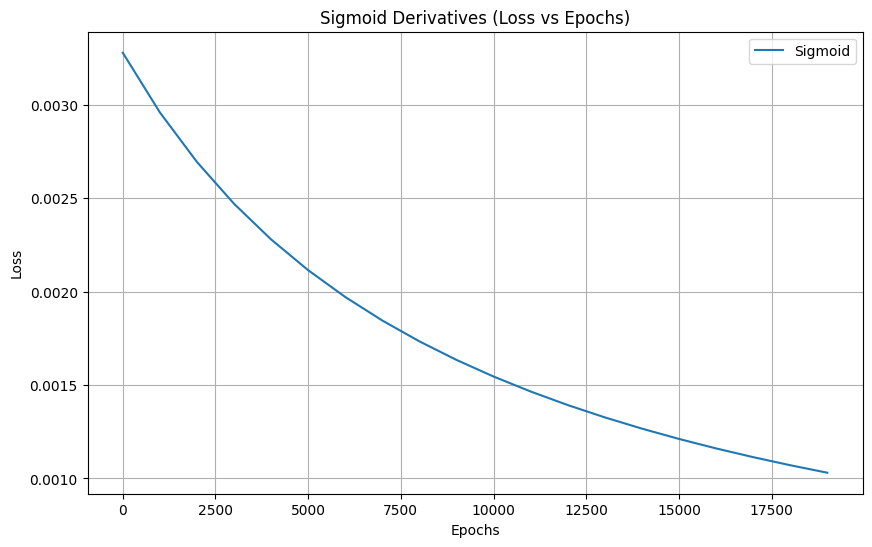

In [56]:
import matplotlib.pyplot as plt

# Collecting loss values during training for sigmoid model
sigmoid_losses = []
for epoch in range(num_epochs):
    output = model_sigmoid.forward(X)
    loss = np.mean((output - Y) ** 2)
    loss_grad = 2 * (output - Y) / len(X)
    model_sigmoid.backward(loss_grad)
    if epoch % 1000 == 0:
        sigmoid_losses.append(loss)
# Plotting loss values for sigmoid and tanh models
plt.figure(figsize=(10, 6))
plt.plot(range(0, num_epochs, 1000), sigmoid_losses, label='Sigmoid')
plt.title('Sigmoid Derivatives (Loss vs Epochs)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


In [57]:
# Creating a neural network with a single hidden layer and tanh activations
model_tanh = Sequential()
model_tanh.add(LinearLayer(2, 2))
model_tanh.add(TanhLayer())
model_tanh.add(LinearLayer(2, 1))
model_tanh.add(SigmoidLayer())
start2=time.time()

for epoch in range(num_epochs):
    output = model_tanh.forward(X)
    
    # Calculate the mean squared error loss
    loss = np.mean((output - Y) ** 2)
    
    # Backpropagation
    loss_grad = 2 * (output - Y) / len(X)
    model_tanh.backward(loss_grad)
    
    if epoch % 1000 == 0:
        print(f'Tanh - Epoch {epoch}: Loss {loss}')
end2=time.time()
time_for_tanh=end2-start2
# Saving the trained weights
model.save_weights('XOR_solved_tanh.w')

predictions = model_tanh.forward(X)
print("Tanh Predictions:")
print(predictions)

Tanh - Epoch 0: Loss 0.23318123065083415
Tanh - Epoch 1000: Loss 0.1358688621370821
Tanh - Epoch 2000: Loss 0.12984703155722796
Tanh - Epoch 3000: Loss 0.12813318004592186
Tanh - Epoch 4000: Loss 0.12731864403534432
Tanh - Epoch 5000: Loss 0.12684047383551456
Tanh - Epoch 6000: Loss 0.126525343118993
Tanh - Epoch 7000: Loss 0.1263018342581293
Tanh - Epoch 8000: Loss 0.12613501759224616
Tanh - Epoch 9000: Loss 0.12600574809140463
Tanh - Epoch 10000: Loss 0.1259026399740546
Tanh - Epoch 11000: Loss 0.12581849209999885
Tanh - Epoch 12000: Loss 0.1257485251496275
Tanh - Epoch 13000: Loss 0.12568944162579024
Tanh - Epoch 14000: Loss 0.12563889252897936
Tanh - Epoch 15000: Loss 0.1255951590758657
Tanh - Epoch 16000: Loss 0.12555695459715882
Tanh - Epoch 17000: Loss 0.12552329677436536
Tanh - Epoch 18000: Loss 0.12549342269063862
Tanh - Epoch 19000: Loss 0.12546673083544616
Tanh Predictions:
[[0.01630651]
 [0.98046686]
 [0.49958242]
 [0.50070526]]


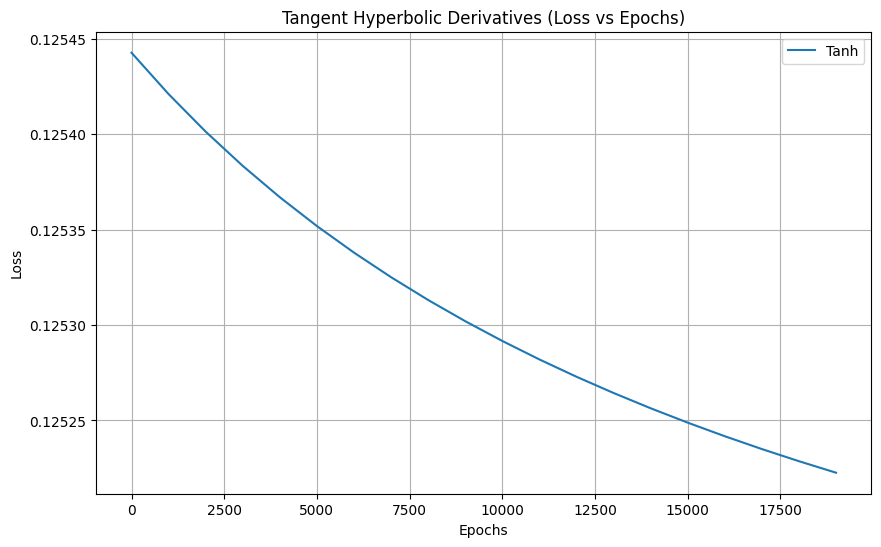

In [58]:
# Collecting loss values during training for tanh model
tanh_losses = []
for epoch in range(num_epochs):
    output = model_tanh.forward(X)
    loss = np.mean((output - Y) ** 2)
    loss_grad = 2 * (output - Y) / len(X)
    model_tanh.backward(loss_grad)
    if epoch % 1000 == 0:
        tanh_losses.append(loss)

# Plotting loss values for sigmoid and tanh models
plt.figure(figsize=(10, 6))
plt.plot(range(0, num_epochs, 1000), tanh_losses, label='Tanh')
plt.title('Tangent Hyperbolic Derivatives (Loss vs Epochs)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


In [13]:
print("Time taken for sigmoid XOR to execute is : ",time_for_sigmoid)
print("Time taken for Tanh XOR to execute is : ",time_for_tanh)
if time_for_sigmoid>time_for_tanh:
    print("Sigmoid was easy to execute")
else:
    print("Tanh was easy to execute")

Time taken for sigmoid XOR to execute is :  1.367645025253296
Time taken for Tanh XOR to execute is :  1.3611726760864258
Sigmoid was easy to execute


In [14]:
dataframe_train=pd.read_csv("train.csv")
dataframe_test=pd.read_csv("test.csv")

In [15]:
dataframe_test

id  vendor_id      pickup_datetime  passenger_count  \
0       id3004672          1  2016-06-30 23:59:58                1   
1       id3505355          1  2016-06-30 23:59:53                1   
2       id1217141          1  2016-06-30 23:59:47                1   
3       id2150126          2  2016-06-30 23:59:41                1   
4       id1598245          1  2016-06-30 23:59:33                1   
...           ...        ...                  ...              ...   
625129  id3008929          1  2016-01-01 00:02:52                1   
625130  id3700764          1  2016-01-01 00:01:52                1   
625131  id2568735          1  2016-01-01 00:01:24                2   
625132  id1384355          1  2016-01-01 00:00:28                1   
625133  id0621643          2  2016-01-01 00:00:22                2   

        pickup_longitude  pickup_latitude  dropoff_longitude  \
0             -73.988129        40.732029         -73.990173   
1             -73.964203        40.679993         -73.959808   
2             -73.997437        40.737583         -73.986160   
3             -73.956070        40.771900         -73.986427   
4             -73.970215        40.761475         -73.961510   
...                  ...              ...                ...   
625129        -74.003464        40.725105         -74.001251   
625130        -74.006363        40.743782         -73.953407   
625131        -73.972267        40.759865         -73.876602   
625132        -73.976501        40.733562         -73.854263   
625133        -73.981850        40.716881         -73.969330   

        dropoff_latitude store_and_fwd_flag  
0              40.756680                  N  
1              40.655403                  N  
2              40.729523                  N  
3              40.730469                  N  
4              40.755890                  N  
...                  ...                ...  
625129         40.733643                  N  
625130         40.782467                  N  
625131         40.748665                  N  
625132         40.891788                  N  
625133         40.769379                  N  

[625134 rows x 9 columns]

In [16]:
dataframe_train

id  vendor_id      pickup_datetime     dropoff_datetime  \
0        id2875421          2  2016-03-14 17:24:55  2016-03-14 17:32:30   
1        id2377394          1  2016-06-12 00:43:35  2016-06-12 00:54:38   
2        id3858529          2  2016-01-19 11:35:24  2016-01-19 12:10:48   
3        id3504673          2  2016-04-06 19:32:31  2016-04-06 19:39:40   
4        id2181028          2  2016-03-26 13:30:55  2016-03-26 13:38:10   
...            ...        ...                  ...                  ...   
1458639  id2376096          2  2016-04-08 13:31:04  2016-04-08 13:44:02   
1458640  id1049543          1  2016-01-10 07:35:15  2016-01-10 07:46:10   
1458641  id2304944          2  2016-04-22 06:57:41  2016-04-22 07:10:25   
1458642  id2714485          1  2016-01-05 15:56:26  2016-01-05 16:02:39   
1458643  id1209952          1  2016-04-05 14:44:25  2016-04-05 14:47:43   

         passenger_count  pickup_longitude  pickup_latitude  \
0                      1        -73.982155        40.767937   
1                      1        -73.980415        40.738564   
2                      1        -73.979027        40.763939   
3                      1        -74.010040        40.719971   
4                      1        -73.973053        40.793209   
...                  ...               ...              ...   
1458639                4        -73.982201        40.745522   
1458640                1        -74.000946        40.747379   
1458641                1        -73.959129        40.768799   
1458642                1        -73.982079        40.749062   
1458643                1        -73.979538        40.781750   

         dropoff_longitude  dropoff_latitude store_and_fwd_flag  trip_duration  
0               -73.964630         40.765602                  N            455  
1               -73.999481         40.731152                  N            663  
2               -74.005333         40.710087                  N           2124  
3               -74.012268         40.706718                  N            429  
4               -73.972923         40.782520                  N            435  
...                    ...               ...                ...            ...  
1458639         -73.994911         40.740170                  N            778  
1458640         -73.970184         40.796547                  N            655  
1458641         -74.004433         40.707371                  N            764  
1458642         -73.974632         40.757107                  N            373  
1458643         -73.972809         40.790585                  N            198  

[1458644 rows x 11 columns]

In [17]:
dataframe_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1458644 entries, 0 to 1458643
Data columns (total 11 columns):
 #   Column              Non-Null Count    Dtype  
---  ------              --------------    -----  
 0   id                  1458644 non-null  object 
 1   vendor_id           1458644 non-null  int64  
 2   pickup_datetime     1458644 non-null  object 
 3   dropoff_datetime    1458644 non-null  object 
 4   passenger_count     1458644 non-null  int64  
 5   pickup_longitude    1458644 non-null  float64
 6   pickup_latitude     1458644 non-null  float64
 7   dropoff_longitude   1458644 non-null  float64
 8   dropoff_latitude    1458644 non-null  float64
 9   store_and_fwd_flag  1458644 non-null  object 
 10  trip_duration       1458644 non-null  int64  
dtypes: float64(4), int64(3), object(4)
memory usage: 122.4+ MB


In [18]:
dataframe_train.isnull().sum()

id                    0
vendor_id             0
pickup_datetime       0
dropoff_datetime      0
passenger_count       0
pickup_longitude      0
pickup_latitude       0
dropoff_longitude     0
dropoff_latitude      0
store_and_fwd_flag    0
trip_duration         0
dtype: int64

In [19]:
dataframe_test.isnull().sum()

id                    0
vendor_id             0
pickup_datetime       0
passenger_count       0
pickup_longitude      0
pickup_latitude       0
dropoff_longitude     0
dropoff_latitude      0
store_and_fwd_flag    0
dtype: int64

In [20]:
dataframe_train['id'].value_counts().index

Index(['id2875421', 'id2249290', 'id2484008', 'id3901436', 'id1265174',
       'id2244272', 'id3023827', 'id3584226', 'id2384320', 'id0086547',
       ...
       'id0583032', 'id1758370', 'id3848969', 'id3462342', 'id0538362',
       'id2478352', 'id1159014', 'id3007971', 'id3965191', 'id1209952'],
      dtype='object', name='id', length=1458644)

In [21]:
dataframe_train.drop("id",axis=1,inplace=True)
dataframe_train

vendor_id      pickup_datetime     dropoff_datetime  passenger_count  \
0                2  2016-03-14 17:24:55  2016-03-14 17:32:30                1   
1                1  2016-06-12 00:43:35  2016-06-12 00:54:38                1   
2                2  2016-01-19 11:35:24  2016-01-19 12:10:48                1   
3                2  2016-04-06 19:32:31  2016-04-06 19:39:40                1   
4                2  2016-03-26 13:30:55  2016-03-26 13:38:10                1   
...            ...                  ...                  ...              ...   
1458639          2  2016-04-08 13:31:04  2016-04-08 13:44:02                4   
1458640          1  2016-01-10 07:35:15  2016-01-10 07:46:10                1   
1458641          2  2016-04-22 06:57:41  2016-04-22 07:10:25                1   
1458642          1  2016-01-05 15:56:26  2016-01-05 16:02:39                1   
1458643          1  2016-04-05 14:44:25  2016-04-05 14:47:43                1   

         pickup_longitude  pickup_latitude  dropoff_longitude  \
0              -73.982155        40.767937         -73.964630   
1              -73.980415        40.738564         -73.999481   
2              -73.979027        40.763939         -74.005333   
3              -74.010040        40.719971         -74.012268   
4              -73.973053        40.793209         -73.972923   
...                   ...              ...                ...   
1458639        -73.982201        40.745522         -73.994911   
1458640        -74.000946        40.747379         -73.970184   
1458641        -73.959129        40.768799         -74.004433   
1458642        -73.982079        40.749062         -73.974632   
1458643        -73.979538        40.781750         -73.972809   

         dropoff_latitude store_and_fwd_flag  trip_duration  
0               40.765602                  N            455  
1               40.731152                  N            663  
2               40.710087                  N           2124  
3               40.706718                  N            429  
4               40.782520                  N            435  
...                   ...                ...            ...  
1458639         40.740170                  N            778  
1458640         40.796547                  N            655  
1458641         40.707371                  N            764  
1458642         40.757107                  N            373  
1458643         40.790585                  N            198  

[1458644 rows x 10 columns]

In [22]:
dataframe_test.drop("id",axis=1,inplace=True)
dataframe_test

vendor_id      pickup_datetime  passenger_count  pickup_longitude  \
0               1  2016-06-30 23:59:58                1        -73.988129   
1               1  2016-06-30 23:59:53                1        -73.964203   
2               1  2016-06-30 23:59:47                1        -73.997437   
3               2  2016-06-30 23:59:41                1        -73.956070   
4               1  2016-06-30 23:59:33                1        -73.970215   
...           ...                  ...              ...               ...   
625129          1  2016-01-01 00:02:52                1        -74.003464   
625130          1  2016-01-01 00:01:52                1        -74.006363   
625131          1  2016-01-01 00:01:24                2        -73.972267   
625132          1  2016-01-01 00:00:28                1        -73.976501   
625133          2  2016-01-01 00:00:22                2        -73.981850   

        pickup_latitude  dropoff_longitude  dropoff_latitude  \
0             40.732029         -73.990173         40.756680   
1             40.679993         -73.959808         40.655403   
2             40.737583         -73.986160         40.729523   
3             40.771900         -73.986427         40.730469   
4             40.761475         -73.961510         40.755890   
...                 ...                ...               ...   
625129        40.725105         -74.001251         40.733643   
625130        40.743782         -73.953407         40.782467   
625131        40.759865         -73.876602         40.748665   
625132        40.733562         -73.854263         40.891788   
625133        40.716881         -73.969330         40.769379   

       store_and_fwd_flag  
0                       N  
1                       N  
2                       N  
3                       N  
4                       N  
...                   ...  
625129                  N  
625130                  N  
625131                  N  
625132                  N  
625133                  N  

[625134 rows x 8 columns]

In [23]:
# Checking whether both columns are same or not
same=0
diff=0
no_of_days=[]
no_minutes=[]
for val1,val2 in zip(dataframe_train['pickup_datetime'],dataframe_train['dropoff_datetime']):
    if val1[:10]==val2[:10]:
        date1 = pd.to_datetime(val1)
        date2 = pd.to_datetime(val2)
        # Calculating the difference in minutes
        minutes_difference = (date2 - date1).total_seconds() / 60
        no_minutes.append(minutes_difference)
        no_of_days.append(0)
        same+=1
    elif val1[:10]!=val2[:10]:
        date1 = pd.to_datetime(val1)
        date2 = pd.to_datetime(val2)
        # Calculating the difference in minutes
        days_difference = (date2 - date1).days
        no_minutes.append(0)
        no_of_days.append(days_difference)
        diff+=1
print(same,diff)

1442133 16511


In [24]:
dataframe_train['no_of_days']=no_of_days
dataframe_train['no_of_minutes']=no_minutes

In [25]:
len(no_of_days)

1458644

In [26]:
dataframe_train.drop(['dropoff_datetime','pickup_datetime'],axis=1,inplace=True)

In [27]:
dataframe_train

vendor_id  passenger_count  pickup_longitude  pickup_latitude  \
0                2                1        -73.982155        40.767937   
1                1                1        -73.980415        40.738564   
2                2                1        -73.979027        40.763939   
3                2                1        -74.010040        40.719971   
4                2                1        -73.973053        40.793209   
...            ...              ...               ...              ...   
1458639          2                4        -73.982201        40.745522   
1458640          1                1        -74.000946        40.747379   
1458641          2                1        -73.959129        40.768799   
1458642          1                1        -73.982079        40.749062   
1458643          1                1        -73.979538        40.781750   

         dropoff_longitude  dropoff_latitude store_and_fwd_flag  \
0               -73.964630         40.765602                  N   
1               -73.999481         40.731152                  N   
2               -74.005333         40.710087                  N   
3               -74.012268         40.706718                  N   
4               -73.972923         40.782520                  N   
...                    ...               ...                ...   
1458639         -73.994911         40.740170                  N   
1458640         -73.970184         40.796547                  N   
1458641         -74.004433         40.707371                  N   
1458642         -73.974632         40.757107                  N   
1458643         -73.972809         40.790585                  N   

         trip_duration  no_of_days  no_of_minutes  
0                  455           0       7.583333  
1                  663           0      11.050000  
2                 2124           0      35.400000  
3                  429           0       7.150000  
4                  435           0       7.250000  
...                ...         ...            ...  
1458639            778           0      12.966667  
1458640            655           0      10.916667  
1458641            764           0      12.733333  
1458642            373           0       6.216667  
1458643            198           0       3.300000  

[1458644 rows x 10 columns]

In [28]:
dataframe_test.drop("pickup_datetime",axis=1,inplace=True)
dataframe_test

vendor_id  passenger_count  pickup_longitude  pickup_latitude  \
0               1                1        -73.988129        40.732029   
1               1                1        -73.964203        40.679993   
2               1                1        -73.997437        40.737583   
3               2                1        -73.956070        40.771900   
4               1                1        -73.970215        40.761475   
...           ...              ...               ...              ...   
625129          1                1        -74.003464        40.725105   
625130          1                1        -74.006363        40.743782   
625131          1                2        -73.972267        40.759865   
625132          1                1        -73.976501        40.733562   
625133          2                2        -73.981850        40.716881   

        dropoff_longitude  dropoff_latitude store_and_fwd_flag  
0              -73.990173         40.756680                  N  
1              -73.959808         40.655403                  N  
2              -73.986160         40.729523                  N  
3              -73.986427         40.730469                  N  
4              -73.961510         40.755890                  N  
...                   ...               ...                ...  
625129         -74.001251         40.733643                  N  
625130         -73.953407         40.782467                  N  
625131         -73.876602         40.748665                  N  
625132         -73.854263         40.891788                  N  
625133         -73.969330         40.769379                  N  

[625134 rows x 7 columns]

In [29]:
dataframe_train['store_and_fwd_flag'].value_counts()

store_and_fwd_flag
N    1450599
Y       8045
Name: count, dtype: int64

In [30]:
dataframe_train=pd.get_dummies(data=dataframe_train,columns=['store_and_fwd_flag'])

In [31]:
dataframe_train

vendor_id  passenger_count  pickup_longitude  pickup_latitude  \
0                2                1        -73.982155        40.767937   
1                1                1        -73.980415        40.738564   
2                2                1        -73.979027        40.763939   
3                2                1        -74.010040        40.719971   
4                2                1        -73.973053        40.793209   
...            ...              ...               ...              ...   
1458639          2                4        -73.982201        40.745522   
1458640          1                1        -74.000946        40.747379   
1458641          2                1        -73.959129        40.768799   
1458642          1                1        -73.982079        40.749062   
1458643          1                1        -73.979538        40.781750   

         dropoff_longitude  dropoff_latitude  trip_duration  no_of_days  \
0               -73.964630         40.765602            455           0   
1               -73.999481         40.731152            663           0   
2               -74.005333         40.710087           2124           0   
3               -74.012268         40.706718            429           0   
4               -73.972923         40.782520            435           0   
...                    ...               ...            ...         ...   
1458639         -73.994911         40.740170            778           0   
1458640         -73.970184         40.796547            655           0   
1458641         -74.004433         40.707371            764           0   
1458642         -73.974632         40.757107            373           0   
1458643         -73.972809         40.790585            198           0   

         no_of_minutes  store_and_fwd_flag_N  store_and_fwd_flag_Y  
0             7.583333                  True                 False  
1            11.050000                  True                 False  
2            35.400000                  True                 False  
3             7.150000                  True                 False  
4             7.250000                  True                 False  
...                ...                   ...                   ...  
1458639      12.966667                  True                 False  
1458640      10.916667                  True                 False  
1458641      12.733333                  True                 False  
1458642       6.216667                  True                 False  
1458643       3.300000                  True                 False  

[1458644 rows x 11 columns]

In [32]:
dataframe_test=pd.get_dummies(data=dataframe_test,columns=['store_and_fwd_flag'])
dataframe_test

vendor_id  passenger_count  pickup_longitude  pickup_latitude  \
0               1                1        -73.988129        40.732029   
1               1                1        -73.964203        40.679993   
2               1                1        -73.997437        40.737583   
3               2                1        -73.956070        40.771900   
4               1                1        -73.970215        40.761475   
...           ...              ...               ...              ...   
625129          1                1        -74.003464        40.725105   
625130          1                1        -74.006363        40.743782   
625131          1                2        -73.972267        40.759865   
625132          1                1        -73.976501        40.733562   
625133          2                2        -73.981850        40.716881   

        dropoff_longitude  dropoff_latitude  store_and_fwd_flag_N  \
0              -73.990173         40.756680                  True   
1              -73.959808         40.655403                  True   
2              -73.986160         40.729523                  True   
3              -73.986427         40.730469                  True   
4              -73.961510         40.755890                  True   
...                   ...               ...                   ...   
625129         -74.001251         40.733643                  True   
625130         -73.953407         40.782467                  True   
625131         -73.876602         40.748665                  True   
625132         -73.854263         40.891788                  True   
625133         -73.969330         40.769379                  True   

        store_and_fwd_flag_Y  
0                      False  
1                      False  
2                      False  
3                      False  
4                      False  
...                      ...  
625129                 False  
625130                 False  
625131                 False  
625132                 False  
625133                 False  

[625134 rows x 8 columns]

In [33]:
dataframe_test

vendor_id  passenger_count  pickup_longitude  pickup_latitude  \
0               1                1        -73.988129        40.732029   
1               1                1        -73.964203        40.679993   
2               1                1        -73.997437        40.737583   
3               2                1        -73.956070        40.771900   
4               1                1        -73.970215        40.761475   
...           ...              ...               ...              ...   
625129          1                1        -74.003464        40.725105   
625130          1                1        -74.006363        40.743782   
625131          1                2        -73.972267        40.759865   
625132          1                1        -73.976501        40.733562   
625133          2                2        -73.981850        40.716881   

        dropoff_longitude  dropoff_latitude  store_and_fwd_flag_N  \
0              -73.990173         40.756680                  True   
1              -73.959808         40.655403                  True   
2              -73.986160         40.729523                  True   
3              -73.986427         40.730469                  True   
4              -73.961510         40.755890                  True   
...                   ...               ...                   ...   
625129         -74.001251         40.733643                  True   
625130         -73.953407         40.782467                  True   
625131         -73.876602         40.748665                  True   
625132         -73.854263         40.891788                  True   
625133         -73.969330         40.769379                  True   

        store_and_fwd_flag_Y  
0                      False  
1                      False  
2                      False  
3                      False  
4                      False  
...                      ...  
625129                 False  
625130                 False  
625131                 False  
625132                 False  
625133                 False  

[625134 rows x 8 columns]

In [34]:
dataframe_train.corr(method="spearman")

vendor_id  passenger_count  pickup_longitude  \
vendor_id              1.000000         0.242517          0.014931   
passenger_count        0.242517         1.000000         -0.008193   
pickup_longitude       0.014931        -0.008193          1.000000   
pickup_latitude        0.007874        -0.009183          0.593087   
dropoff_longitude      0.005832        -0.006712          0.395363   
dropoff_latitude       0.006046        -0.004622          0.310839   
trip_duration          0.009245         0.026348          0.025935   
no_of_days            -0.001776        -0.000280          0.001949   
no_of_minutes          0.004768         0.023200          0.026275   
store_and_fwd_flag_N   0.079872         0.017569         -0.007505   
store_and_fwd_flag_Y  -0.079872        -0.017569          0.007505   

                      pickup_latitude  dropoff_longitude  dropoff_latitude  \
vendor_id                    0.007874           0.005832          0.006046   
passenger_count             -0.009183          -0.006712         -0.004622   
pickup_longitude             0.593087           0.395363          0.310839   
pickup_latitude              1.000000           0.291149          0.506934   
dropoff_longitude            0.291149           1.000000          0.541474   
dropoff_latitude             0.506934           0.541474          1.000000   
trip_duration               -0.107242           0.067013         -0.122327   
no_of_days                  -0.002049           0.000150         -0.000006   
no_of_minutes               -0.097151           0.058961         -0.114474   
store_and_fwd_flag_N         0.003941          -0.006494          0.006335   
store_and_fwd_flag_Y        -0.003941           0.006494         -0.006335   

                      trip_duration  no_of_days  no_of_minutes  \
vendor_id                  0.009245   -0.001776       0.004768   
passenger_count            0.026348   -0.000280       0.023200   
pickup_longitude           0.025935    0.001949       0.026275   
pickup_latitude           -0.107242   -0.002049      -0.097151   
dropoff_longitude          0.067013    0.000150       0.058961   
dropoff_latitude          -0.122327   -0.000006      -0.114474   
trip_duration              1.000000    0.002868       0.960189   
no_of_days                 0.002868    1.000000      -0.002836   
no_of_minutes              0.960189   -0.002836       1.000000   
store_and_fwd_flag_N      -0.018317    0.000123      -0.018297   
store_and_fwd_flag_Y       0.018317   -0.000123       0.018297   

                      store_and_fwd_flag_N  store_and_fwd_flag_Y  
vendor_id                         0.079872             -0.079872  
passenger_count                   0.017569             -0.017569  
pickup_longitude                 -0.007505              0.007505  
pickup_latitude                   0.003941             -0.003941  
dropoff_longitude                -0.006494              0.006494  
dropoff_latitude                  0.006335             -0.006335  
trip_duration                    -0.018317              0.018317  
no_of_days                        0.000123             -0.000123  
no_of_minutes                    -0.018297              0.018297  
store_and_fwd_flag_N              1.000000             -1.000000  
store_and_fwd_flag_Y             -1.000000              1.000000

In [35]:
dataframe_train.describe()

vendor_id  passenger_count  pickup_longitude  pickup_latitude  \
count  1.458644e+06     1.458644e+06      1.458644e+06     1.458644e+06   
mean   1.534950e+00     1.664530e+00     -7.397349e+01     4.075092e+01   
std    4.987772e-01     1.314242e+00      7.090186e-02     3.288119e-02   
min    1.000000e+00     0.000000e+00     -1.219333e+02     3.435970e+01   
25%    1.000000e+00     1.000000e+00     -7.399187e+01     4.073735e+01   
50%    2.000000e+00     1.000000e+00     -7.398174e+01     4.075410e+01   
75%    2.000000e+00     2.000000e+00     -7.396733e+01     4.076836e+01   
max    2.000000e+00     9.000000e+00     -6.133553e+01     5.188108e+01   

       dropoff_longitude  dropoff_latitude  trip_duration    no_of_days  \
count       1.458644e+06      1.458644e+06   1.458644e+06  1.458644e+06   
mean       -7.397342e+01      4.075180e+01   9.594923e+02  7.541251e-05   
std         7.064327e-02      3.589056e-02   5.237432e+03  4.711545e-02   
min        -1.219333e+02      3.218114e+01   1.000000e+00  0.000000e+00   
25%        -7.399133e+01      4.073588e+01   3.970000e+02  0.000000e+00   
50%        -7.397975e+01      4.075452e+01   6.620000e+02  0.000000e+00   
75%        -7.396301e+01      4.076981e+01   1.075000e+03  0.000000e+00   
max        -6.133553e+01      4.392103e+01   3.526282e+06  4.000000e+01   

       no_of_minutes  
count   1.458644e+06  
mean    1.374508e+01  
std     1.195051e+01  
min     0.000000e+00  
25%     6.450000e+00  
50%     1.085000e+01  
75%     1.766667e+01  
max     1.435667e+03

In [36]:
# Since no_of_minutes column is not there in X_test so it also cannot be used in X_train
X=np.array(dataframe_train.loc[:,['vendor_id','passenger_count','pickup_latitude','dropoff_latitude']])
Y=np.array(dataframe_train['trip_duration'])

In [37]:
X_test=np.array(dataframe_test.loc[:,['vendor_id','passenger_count','pickup_latitude','dropoff_latitude']])

In [38]:
X_test.shape

(625134, 4)

In [39]:
X.shape

(1458644, 4)

In [40]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X= scaler.fit_transform(X)

In [41]:
dataframe_train.corr(method="spearman")

vendor_id  passenger_count  pickup_longitude  \
vendor_id              1.000000         0.242517          0.014931   
passenger_count        0.242517         1.000000         -0.008193   
pickup_longitude       0.014931        -0.008193          1.000000   
pickup_latitude        0.007874        -0.009183          0.593087   
dropoff_longitude      0.005832        -0.006712          0.395363   
dropoff_latitude       0.006046        -0.004622          0.310839   
trip_duration          0.009245         0.026348          0.025935   
no_of_days            -0.001776        -0.000280          0.001949   
no_of_minutes          0.004768         0.023200          0.026275   
store_and_fwd_flag_N   0.079872         0.017569         -0.007505   
store_and_fwd_flag_Y  -0.079872        -0.017569          0.007505   

                      pickup_latitude  dropoff_longitude  dropoff_latitude  \
vendor_id                    0.007874           0.005832          0.006046   
passenger_count             -0.009183          -0.006712         -0.004622   
pickup_longitude             0.593087           0.395363          0.310839   
pickup_latitude              1.000000           0.291149          0.506934   
dropoff_longitude            0.291149           1.000000          0.541474   
dropoff_latitude             0.506934           0.541474          1.000000   
trip_duration               -0.107242           0.067013         -0.122327   
no_of_days                  -0.002049           0.000150         -0.000006   
no_of_minutes               -0.097151           0.058961         -0.114474   
store_and_fwd_flag_N         0.003941          -0.006494          0.006335   
store_and_fwd_flag_Y        -0.003941           0.006494         -0.006335   

                      trip_duration  no_of_days  no_of_minutes  \
vendor_id                  0.009245   -0.001776       0.004768   
passenger_count            0.026348   -0.000280       0.023200   
pickup_longitude           0.025935    0.001949       0.026275   
pickup_latitude           -0.107242   -0.002049      -0.097151   
dropoff_longitude          0.067013    0.000150       0.058961   
dropoff_latitude          -0.122327   -0.000006      -0.114474   
trip_duration              1.000000    0.002868       0.960189   
no_of_days                 0.002868    1.000000      -0.002836   
no_of_minutes              0.960189   -0.002836       1.000000   
store_and_fwd_flag_N      -0.018317    0.000123      -0.018297   
store_and_fwd_flag_Y       0.018317   -0.000123       0.018297   

                      store_and_fwd_flag_N  store_and_fwd_flag_Y  
vendor_id                         0.079872             -0.079872  
passenger_count                   0.017569             -0.017569  
pickup_longitude                 -0.007505              0.007505  
pickup_latitude                   0.003941             -0.003941  
dropoff_longitude                -0.006494              0.006494  
dropoff_latitude                  0.006335             -0.006335  
trip_duration                    -0.018317              0.018317  
no_of_days                        0.000123             -0.000123  
no_of_minutes                    -0.018297              0.018297  
store_and_fwd_flag_N              1.000000             -1.000000  
store_and_fwd_flag_Y             -1.000000              1.000000

In [42]:
list_of_lists = [[item] for item in Y]

Y=np.array(list_of_lists)
Y

array([[ 455],
       [ 663],
       [2124],
       ...,
       [ 764],
       [ 373],
       [ 198]], dtype=int64)

In [43]:
from mlxtend.preprocessing import shuffle_arrays_unison
n=int(input("Enter what percent of dataset you want to use as trainset since computer configurations are not that high : "))
n=int((n/100)*X.shape[0])
X, Y = shuffle_arrays_unison(arrays=[X, Y], random_seed=3)
X_sample,Y_sample=X[:n],Y[:n]

Enter what percent of dataset you want to use as trainset since computer configurations are not that high :  80


In [44]:
X_sample.shape

(1166915, 4)

In [45]:
Y_sample.shape

(1166915, 1)

C:\Users\sathv_npoekix\AppData\Local\Temp\ipykernel_13092\3593557688.py:59: RuntimeWarning: invalid value encountered in log1p
  log_pred=np.log1p(output)


Epoch 0: Training Loss 0.7179141418156364, Validation Loss 0.8703504855701707
Epoch 1: Training Loss 0.8410710764557123, Validation Loss 0.8296414715166315
Epoch 2: Training Loss 0.8402699290519016, Validation Loss 0.8377824795333686
Epoch 3: Training Loss 0.6490147919188873, Validation Loss 0.8103023091619899
Epoch 4: Training Loss 0.6907979312119255, Validation Loss 0.9111642512061688
Epoch 5: Training Loss 0.6423164287476051, Validation Loss 1.1096002057437948
Epoch 6: Training Loss 0.8326049833495183, Validation Loss 0.8507961137794274
The model here has learning rate :0.1, hidden layer size (16, 16),batch size 16

Epoch 0: Training Loss 0.7578950000256618, Validation Loss 0.9046804155648364
Epoch 1: Training Loss 0.7873618220325985, Validation Loss 0.8709704414990047
Epoch 2: Training Loss 0.6297950593451377, Validation Loss 0.8825636677172115
The model here has learning rate :0.1, hidden layer size (16, 16),batch size 32

Epoch 0: Training Loss 0.49678289306354223, Validation Los

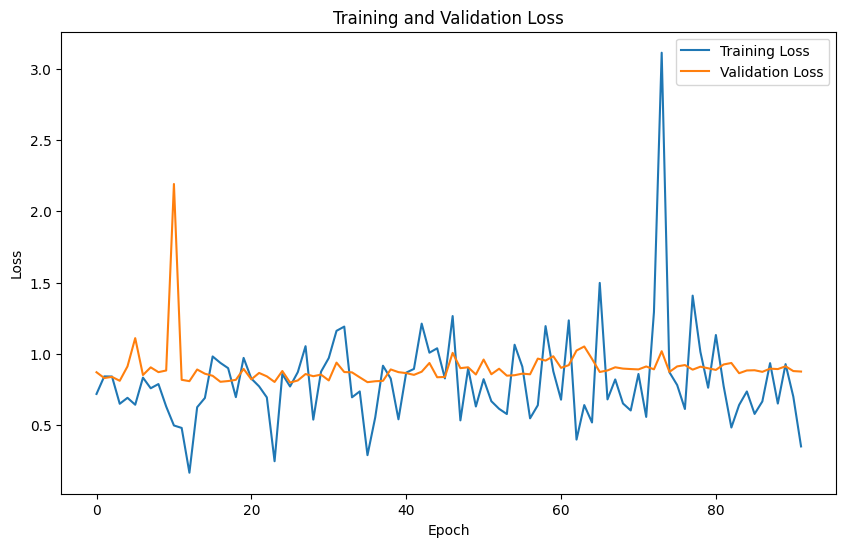

Best Hyperparameters: {'learning_rate': 0.1, 'hidden_layer_size': (32, 32), 'batch_size': 8}
Best Loss: 0.7978548506141749
Test Output:  [[844.09103625]
 [844.09103625]
 [844.09103625]
 ...
 [844.09103625]
 [844.09103625]
 [844.09103625]]


In [46]:
# Split the data into training, validation, and test sets
split_ratio = 0.05  # 5% for validation
split_index = int(X_sample.shape[0] * split_ratio)
X_train = X_sample[split_index:]
Y_train = Y_sample[split_index:]
X_val = X_sample[:split_index]
Y_val = Y_sample[:split_index]

# Define hyperparameter search space
learning_rates = [0.1, 0.01, 0.001]
hidden_layer_sizes = [(16, 16), (32, 32),(64,64)]
batch_sizes = [16, 32,8]

best_loss = float('inf')
best_model = None
best_hyperparameters = {}

# Lists to store training and validation losses for plotting
train_losses = []
val_losses = []

# Hyperparameter tuning loop
for learning_rate in learning_rates:
    for hidden_layer_size in hidden_layer_sizes:
        for batch_size in batch_sizes:
            # Create a neural network for regression
            model_regression = Sequential()
            model_regression.add(LinearLayer(X_train.shape[1], hidden_layer_size[0]))  # Input layer
            model_regression.add(TanhLayer())  # Activation function (ReLU) for hidden layers
            model_regression.add(LinearLayer(hidden_layer_size[0], hidden_layer_size[1]))  # Hidden layer
            model_regression.add(TanhLayer())
            model_regression.add(LinearLayer(hidden_layer_size[1], 1))  # Output layer with 1 neuron for regression
            model_regression.add(LinearLayer(1, 1))  # Linear output layer

            # Training parameters
            num_epochs = 20000  # Increased number of training epochs
            gradient_clip = 1.0  # Gradient clipping

            # Initialize early stopping variables
            early_stopping_count = 0
            early_stopping_patience = 3

            # Training loop for regression with gradient clipping
            for epoch in range(num_epochs):
                # Shuffle the data for each epoch
                indices = np.arange(len(X_train))
                np.random.shuffle(indices)
                X_shuffled = X_train[indices]
                Y_shuffled = Y_train[indices]

                for i in range(0, len(X_train), batch_size):
                    X_batch = X_shuffled[i:i+batch_size]
                    Y_batch = Y_shuffled[i:i+batch_size]

                    # Forward pass
                    output = model_regression.forward(X_batch)

                    # Calculate the Mean Squared Error (MSE) loss for regression
                    log_pred=np.log1p(output)
                    log_actual=np.log1p(Y_batch)
                    # loss = np.mean((output - Y_batch) ** 2)
                    loss_mse=np.mean((log_pred-log_actual)**2)
                    loss=np.sqrt(loss_mse)

                    # Backpropagation with gradient clipping
                    loss_grad = 2 * (output - Y_batch) / len(X_batch)
                    model_regression.backward(loss_grad)

                    # Gradient clipping to prevent exploding gradients
                    for layer in model_regression.layers:
                        if isinstance(layer, LinearLayer):
                            layer.weights = np.clip(layer.weights, -gradient_clip, gradient_clip)

                # Calculate validation loss
                val_output = model_regression.forward(X_val)
                val_mse = np.mean((np.log1p(val_output) - np.log1p(Y_val)) ** 2)
                val_loss=np.sqrt(val_mse)

                # Track training and validation losses for plotting
                train_losses.append(loss)
                val_losses.append(val_loss)

#                 if epoch % 1000 == 0:
                print(f'Epoch {epoch}: Training Loss {loss}, Validation Loss {val_loss}')

                # Check for early stopping
                if val_loss < best_loss:
                    best_loss = val_loss
                    best_model = model_regression
                    best_hyperparameters = {
                        "learning_rate": learning_rate,
                        "hidden_layer_size": hidden_layer_size,
                        "batch_size": batch_size
                    }
                    early_stopping_count = 0
                else:
                    early_stopping_count += 1
                    if early_stopping_count >= early_stopping_patience:
                        print(f"The model here has learning rate :{learning_rate}, hidden layer size {hidden_layer_size},batch size {batch_size}")
                        print()
                        break

# Plot training and validation losses
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

print("Best Hyperparameters:", best_hyperparameters)
print("Best Loss:", best_loss)


test_output = best_model.forward(X_test)
print("Test Output: ", test_output)
